In [1]:
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import requests

from geopy.exc import GeocoderUnavailable
from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.display import display
from pathlib import Path
from scipy import stats

In [2]:
# Load in the relevant datasets

# DALYs by country
# DALYs are Disabililty Adjusted Life Years. This refers to the average number of years a citizen's life is shortened due to a disability (i.e. mental illness).
dalys_df = pd.read_csv(Path('mental_health_dataset', 'mental-and-substance-use-as-share-of-disease.csv'))
dalys_df = dalys_df.rename(columns={'DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)' : 'DALYs'})

# Prevalance of mental illness by country as a percentage of the country's population
# The illnesses observed are schizophrenia, bipolar disorder, eating disorders, anxiety disorders, drug use disorders,depressive disorders, and alcohol use disorders
disease_df = pd.read_csv(Path('mental_health_dataset', 'prevalence-by-mental-and-substance-use-disorder.csv'))
disease_df = disease_df.rename(columns={
    'Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent)' : 'Schizophrenia',
    'Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent)' : 'Bipolar disorder',
    'Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Eating disorders',
    'Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Anxiety disorders',
    'Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Drug use disorders',
    'Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Depressive disorders',
    'Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)' : 'Alcohol use disorders'
})

# Data Cleaning

In [3]:
dalys_df.dropna()
dalys_df.describe().loc[['min', 'max']].astype(float)

,Year,DALYs
min,1990.0,0.215647
max,2019.0,13.761517


## Observations
-  All N/A value have been removed from the DALYs dataset.<br>
-  The minimum and maximum years fall within the expect range (1990-2019).<br>
-  The minimum DALYs is greater than 0. Mental illness is not expected to prolong life. <br>
-  The maximum DALYs is below 14 years. This value is expected to be lower than a human lifespan.

In [4]:
disease_df.dropna()
disease_df.describe().loc[['min', 'max']].astype(float)

,Year,Schizophrenia,Bipolar disorder,Eating disorders,Anxiety disorders,Drug use disorders,Depressive disorders,Alcohol use disorders
min,1990.0,0.191621,0.189344,0.045425,1.974823,0.225471,1.640902,0.319900
max,2019.0,0.506018,1.676204,1.136541,9.015948,3.699504,7.688213,4.698694


## Observations
-  All N/A value have been removed from the diseases dataset.<br>
-  The minimum and maximum years fall within the expect range (1990-2019).<br>
-  The value for each disorder represents a percentage of a country's population. The lowest values should be greater than or (in a perfect world) equal to zero. The greatest values should not be a majority of the population of a country. 9.015948% seems to be a reasonable maximum value. This is the opinion of a data analyst, not a mental health professional.

# Question #1 - Is there a difference in mental health among geographical regions?

In [5]:
# Perform geographic analysis. This will require coordinates for each country which can be queried through the geopy library.
# This can take a while, so only run this cell if you don't already have the data saved locally.

# Country code 'NA' exists so it should be removed from the na_values list
na_values = [' ', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 
             'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null ']

# Country codes are necessary to differentiate between 2 similarly named regions (i.e. Georgia the state and country)
country_codes_df = pd.read_csv(Path('geodata', 'country_codes.csv'), na_values = na_values, keep_default_na = False)

# Get the list of countries from the DALYs dataset
geo_df = pd.DataFrame(dalys_df['Entity'].unique(), columns=['Entity'])

# Merge countries with codes
geo_df = geo_df.merge(country_codes_df, on='Entity')

# Query for coordinates
geolocator = Nominatim(user_agent='data_science_student_project')
lat = []
lon = []

for country, code in zip(geo_df['Entity'], geo_df['Code']):
    print(f'Retrieving geodata for {country}...')
    try:
        # Get the geodata
        geodata = geolocator.geocode(country, country_codes=code)

        # Pull out the latitude and longitude
        try:
            lat.append(geodata.latitude)
        except AttributeError:
            lat.append('N/A')
            print(f'Latitude not for {country}.')
        try:
            lon.append(geodata.longitude)
        except AttributeError:
            lon.append('N/A')
            print(f'Longitude not for {country}.')
    except (TimeoutError, GeocoderUnavailable):
        lat.append('N/A')
        print(f'Latitude not for {country}.')
        lon.append('N/A')
        print(f'Longitude not for {country}.')

print('''
*******************************
Geodata retrieval complete!
*******************************''')

Retrieving geodata for Afghanistan...
Retrieving geodata for Albania...
Retrieving geodata for Algeria...
Retrieving geodata for American Samoa...
Latitude not for American Samoa.
Longitude not for American Samoa.
Retrieving geodata for Andorra...
Retrieving geodata for Angola...
Retrieving geodata for Antigua and Barbuda...
Retrieving geodata for Argentina...
Retrieving geodata for Armenia...
Retrieving geodata for Australia...
Retrieving geodata for Austria...
Retrieving geodata for Azerbaijan...
Retrieving geodata for Bahamas...
Retrieving geodata for Bahrain...
Retrieving geodata for Bangladesh...
Retrieving geodata for Barbados...
Retrieving geodata for Belarus...
Retrieving geodata for Belgium...
Retrieving geodata for Belize...
Retrieving geodata for Benin...
Retrieving geodata for Bermuda...
Retrieving geodata for Bhutan...
Retrieving geodata for Bolivia...
Retrieving geodata for Bosnia and Herzegovina...
Retrieving geodata for Botswana...
Retrieving geodata for Brazil...
Retri

In [6]:
# Save geodata for later use. It is easier to read the data from a local .csv than to perform all the geodata queries again.
pd.DataFrame({
    'Entity' : geo_df['Entity'],
    'Latitude' : lat,
    'Longitude' : lon
}).to_csv(Path('geodata', 'coordinates.csv'), index=False)

In [7]:
# Load geodata if not already loaded into the notebook
geo_df = pd.read_csv(Path('geodata', 'coordinates.csv'))

In [8]:
# Merge geodata with DALYs data
geo_df = geo_df.merge(dalys_df, on='Entity')
geo_df = geo_df.dropna()
geo_df

,Entity,Latitude,Longitude,Code,Year,DALYs
0,Afghanistan,33.768006,66.238514,AFG,1990,1.696670
1,Afghanistan,33.768006,66.238514,AFG,1991,1.734281
2,Afghanistan,33.768006,66.238514,AFG,1992,1.791189
3,Afghanistan,33.768006,66.238514,AFG,1993,1.776779
4,Afghanistan,33.768006,66.238514,AFG,1994,1.712986
...,...,...,...,...,...,...
6055,Zimbabwe,-18.455496,29.746841,ZWE,2015,2.193166
6056,Zimbabwe,-18.455496,29.746841,ZWE,2016,2.279813
6057,Zimbabwe,-18.455496,29.746841,ZWE,2017,2.364265
6058,Zimbabwe,-18.455496,29.746841,ZWE,2018,2.472949


In [9]:
# Create a map to visually inspect for regional trends. We will arbitrarily use the latest year in the dataset, 2019.
year = 2019
dalys_map = geo_df[geo_df['Year'] == year].hvplot.points(
    'Longitude',
    'Latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
    size = 'DALYs',
    color = 'Entity',
    alpha = 0.5,
    scale = 6,
    title = f'DALYs in {year} by Country (indicated by dot size)'
)
hvplot.save(dalys_map, Path('media', 'dalys_map.html'))
dalys_map

c:\Users\Matthew\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Entity,DALYs)

## Observations
Africa has noticeably smaller DALYs than the Americas, Europe, and the Middle East. Let's dig into the statistics to find out more.

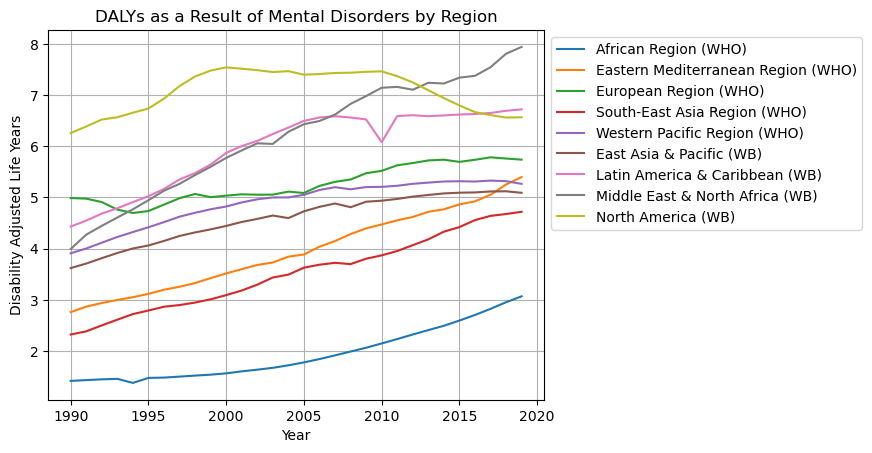

,count,mean,std,min,25%,50%,75%,max
Entity,,,,,,,,
African Region (WHO),30.0,1.940398,0.515247,1.378090,1.506294,1.750572,2.301569,3.069142
South-East Asia Region (WHO),30.0,3.517538,0.726899,2.323155,2.910889,3.560689,4.039802,4.720232
Eastern Mediterranean Region (WHO),30.0,3.956516,0.780661,2.760770,3.274324,3.865009,4.602252,5.398671
East Asia & Pacific (WB),30.0,4.591208,0.469133,3.620257,4.265443,4.688283,5.004946,5.120409
Western Pacific Region (WHO),30.0,4.897136,0.437364,3.910267,4.643972,5.026614,5.256426,5.329064
European Region (WHO),30.0,5.258247,0.358108,4.697142,4.992851,5.100676,5.660788,5.783628
Latin America & Caribbean (WB),30.0,5.970586,0.759604,4.431947,5.382909,6.301551,6.588916,6.720816
Middle East & North Africa (WB),30.0,6.192522,1.133270,3.993599,5.308950,6.356445,7.155375,7.939938
North America (WB),30.0,7.065665,0.416479,6.257477,6.658154,7.211062,7.445974,7.540770


In [10]:
# The DALYs dataset also includes regional data, which we will extract, plot, and analyze below.
regions = ['African Region (WHO)', 'Eastern Mediterranean Region (WHO)', 'European Region (WHO)', 'South-East Asia Region (WHO)', 
           'Western Pacific Region (WHO)', 'East Asia & Pacific (WB)', 'Latin America & Caribbean (WB)', 'Middle East & North Africa (WB)', 
           'North America (WB)']
regions_df = pd.DataFrame()

for r in regions:
    df = dalys_df[dalys_df['Entity'] == r]
    regions_df = pd.concat([regions_df, df])
    plt.plot(df['Year'], df['DALYs'])

plt.title('DALYs as a Result of Mental Disorders by Region')
plt.xlabel('Year')
plt.ylabel('Disability Adjusted Life Years')
plt.legend(regions, bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig(Path('media', 'dalys_by_region.png'), bbox_inches="tight")
plt.show()

regions_stats = regions_df.groupby('Entity')['DALYs'].describe().sort_values('mean')
regions_stats.to_csv(Path('media', 'dalys_stats.csv'))
regions_stats

## Observations
-  The population of the African region clearly experiences lower DALYs than all other regions, with the smallest mean, minimum value, and maxiumum value.<br>
-  The population of North America was the most mentally unhealthy starting at 1990, but begins to recover after 2010. The DALYs dip below Latin America and the Caribbean in 2017 before leveling off.<br>
-  The DALYs for Latin America and the Caribbean appear to keep pace with the Middle East and North Africa, but then level out in 2006 while the latter region's DALYs continue to grow. This diversion could be worth further investigation.<br>
-  The European region DALYs had the smallest standard deviation over the timespan, indicating the smallest fluctuation in mental health.<br>
-  Across all regions, mental health appears to be **trending for the worse**.

# Question #2 - What are the most frequently occurring mental disorders?

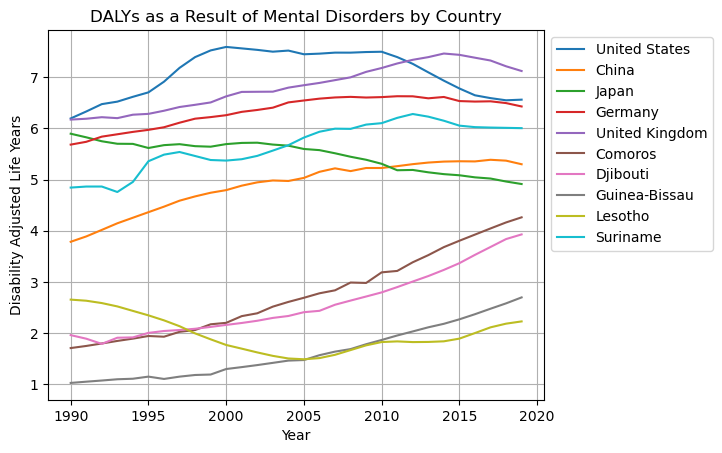

In [11]:
# For this analysis, we will look at the top and bottom 5 wealthiest countries.
countries_of_interest = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom',    # Wealthiest countries
                         'Comoros', 'Djibouti', 'Guinea-Bissau', 'Lesotho', 'Suriname']     # Poorest countries

for c in countries_of_interest:
    df = dalys_df[dalys_df['Entity'] == c]
    plt.plot(df['Year'], df['DALYs'])

plt.legend(countries_of_interest)
plt.title('DALYs as a Result of Mental Disorders by Country')
plt.xlabel('Year')
plt.ylabel('Disability Adjusted Life Years')
plt.legend(countries_of_interest, bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

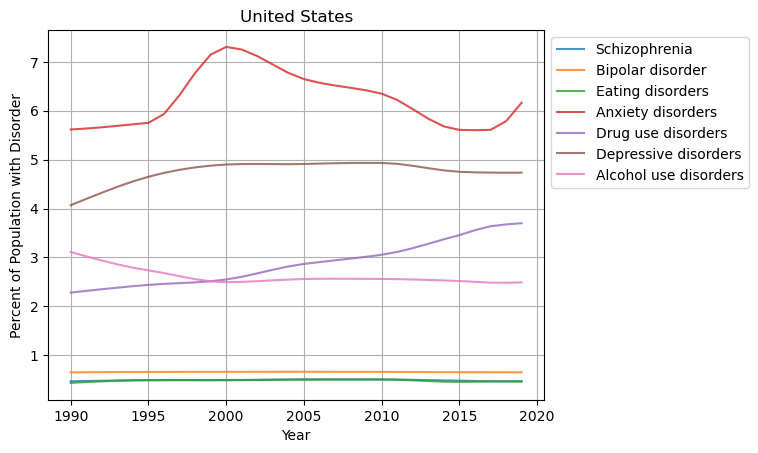

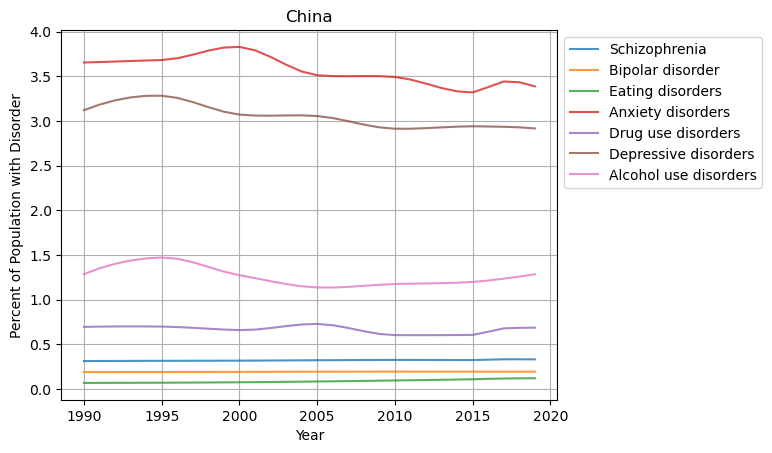

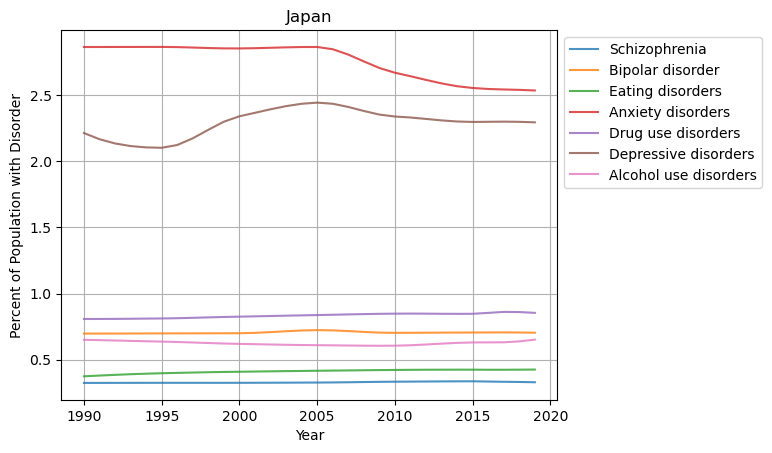

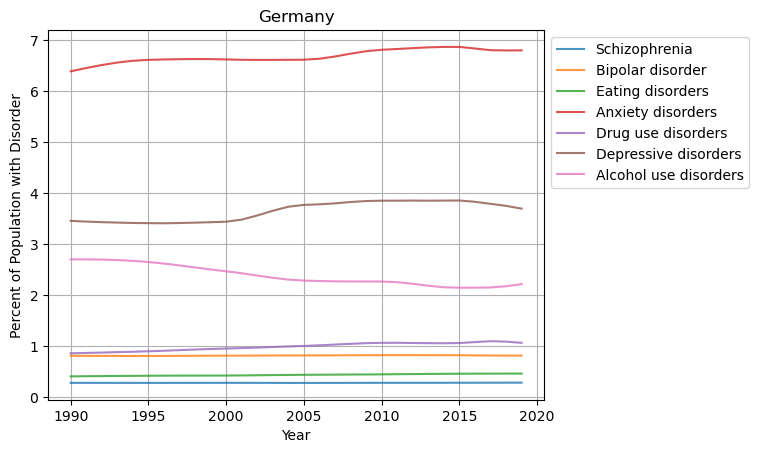

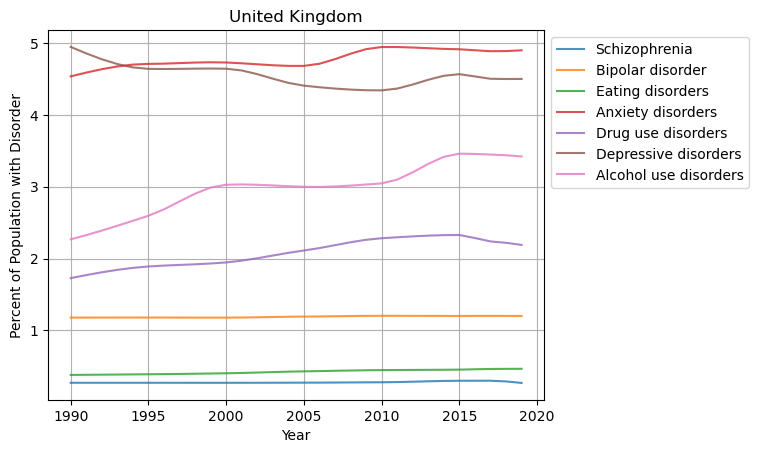

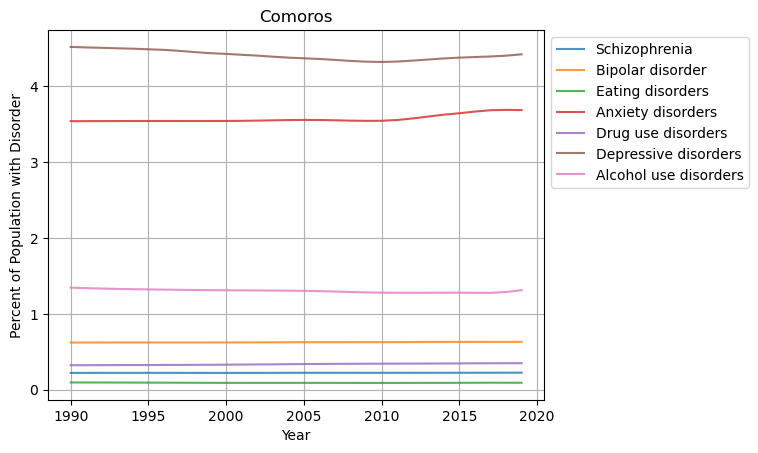

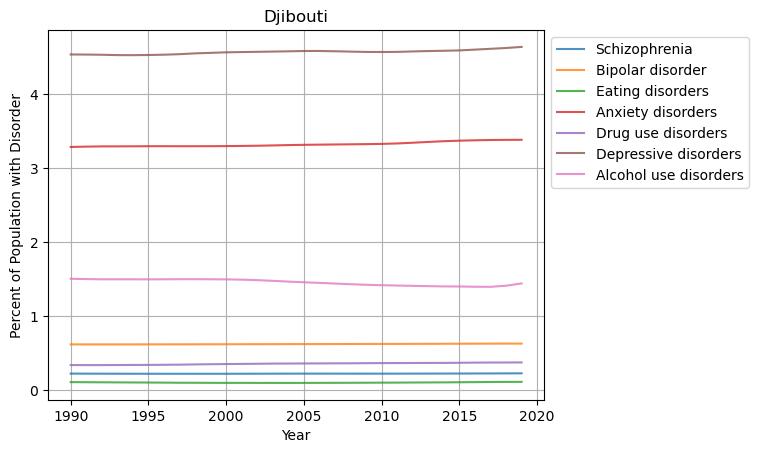

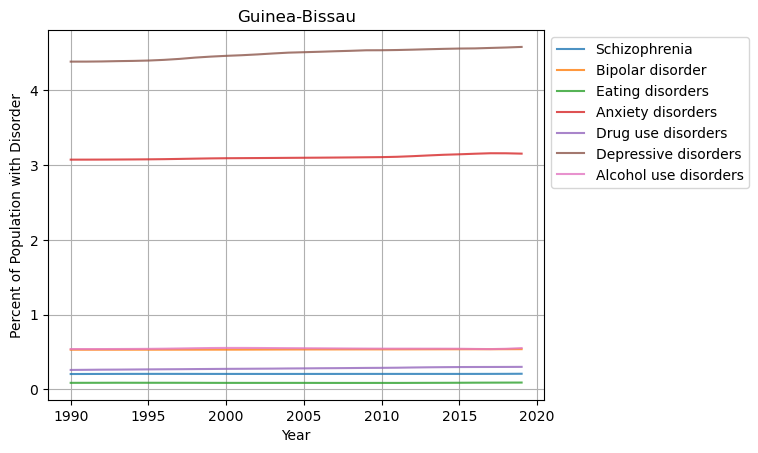

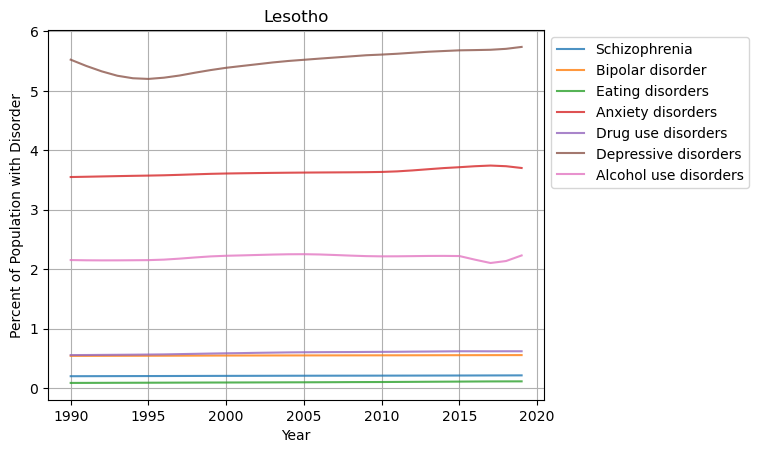

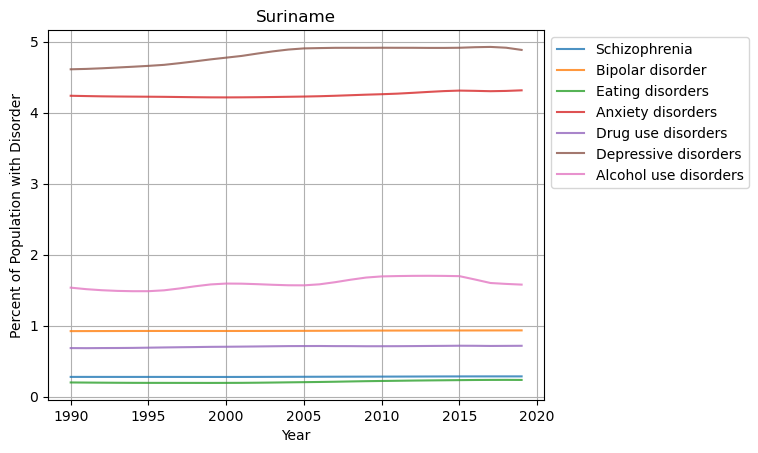

In [12]:
# For this analysis, we will look at the distribution of mental illnesses within our countries of interest.
diseases = ['Schizophrenia', 'Bipolar disorder', 'Eating disorders', 'Anxiety disorders','Drug use disorders','Depressive disorders', 'Alcohol use disorders']

for c in countries_of_interest:
    df = disease_df[disease_df['Entity'] == c]
    for d in diseases:
        plt.plot(df['Year'], df[d], alpha=0.8)
    plt.title(c)
    plt.xlabel('Year')
    plt.ylabel('Percent of Population with Disorder')
    plt.legend(diseases, bbox_to_anchor=(1, 1))
    plt.grid()
    plt.savefig(Path('media', f"disorders_in_{c.replace(' ', '_')}.png"), bbox_inches="tight")
    plt.show()

## Observations
Across the board, the two disorders that are most prevalent in each listed country are anxiety and depressive disorders. The two disorders that are least prevalent are eating disorders and schizophrenia. Alcohol disorders fall in the middle in every graph.
The United Kingdom is the only country in which bipolar disorders have affected above 1% of the population. The United States is the only country where drug and alcohol abuse is above 2%.

# Question 3 - Between the US and UK, which country is mentally healthier?

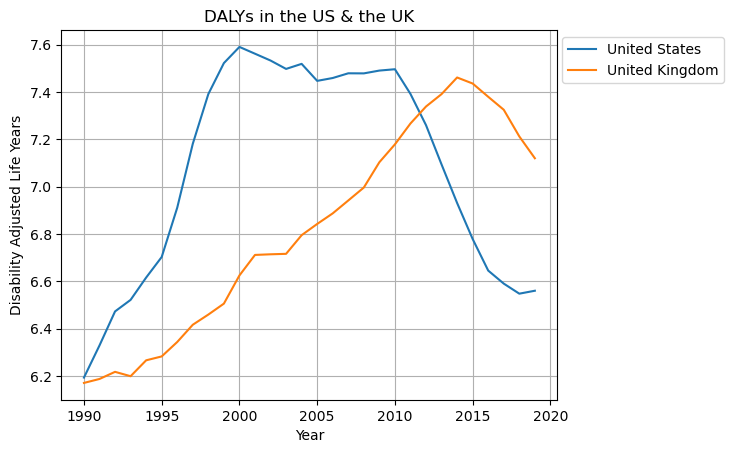

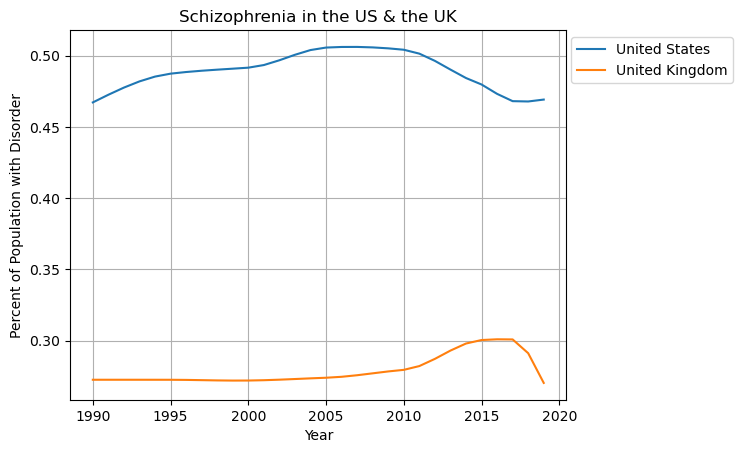

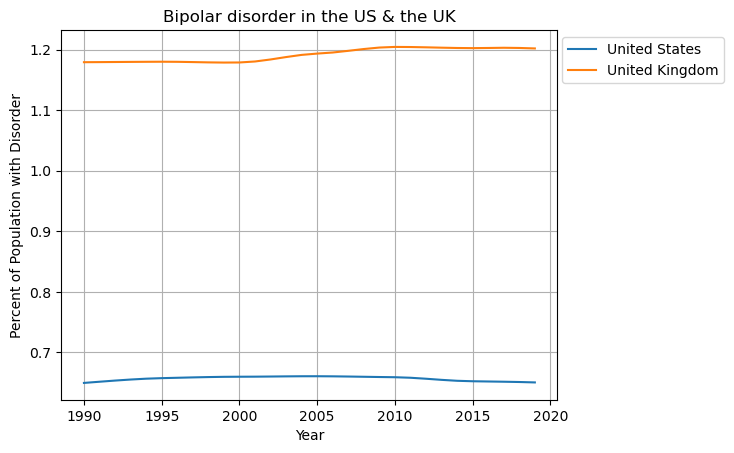

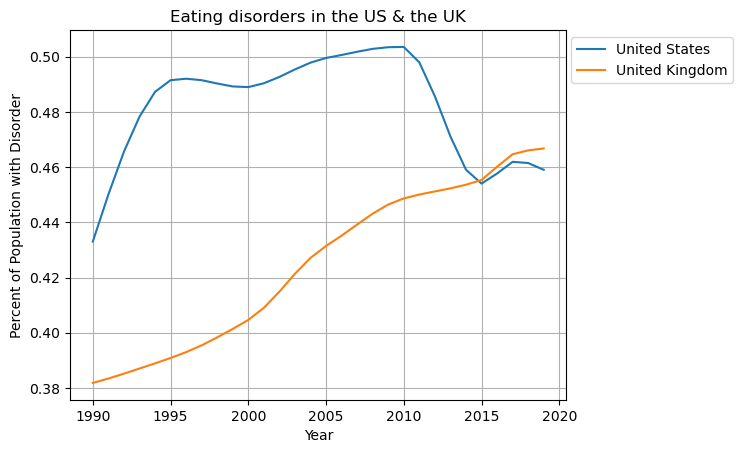

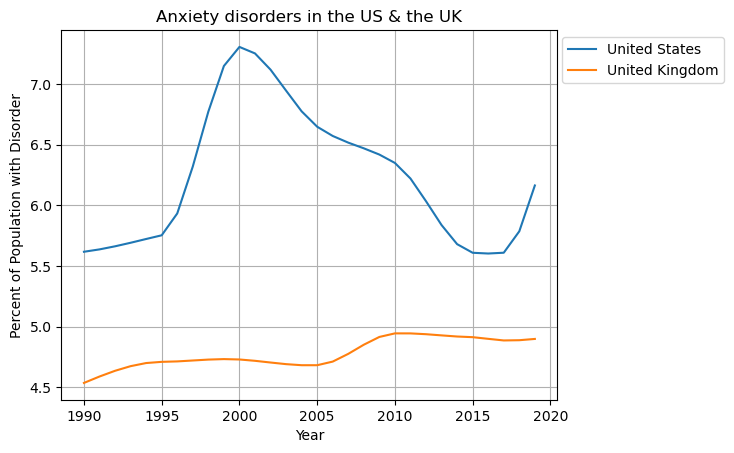

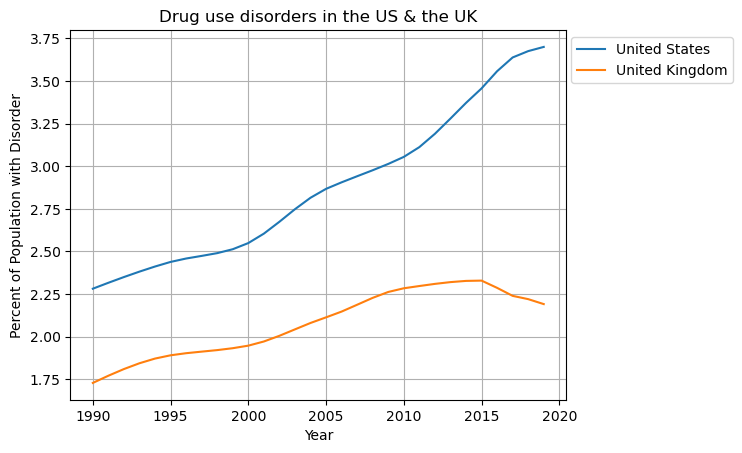

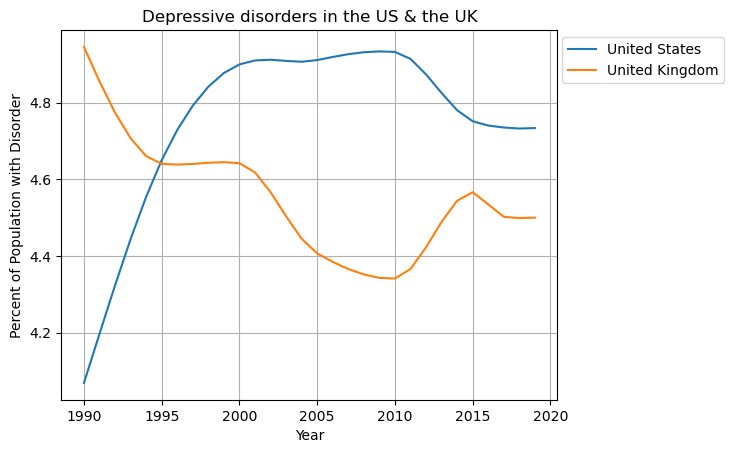

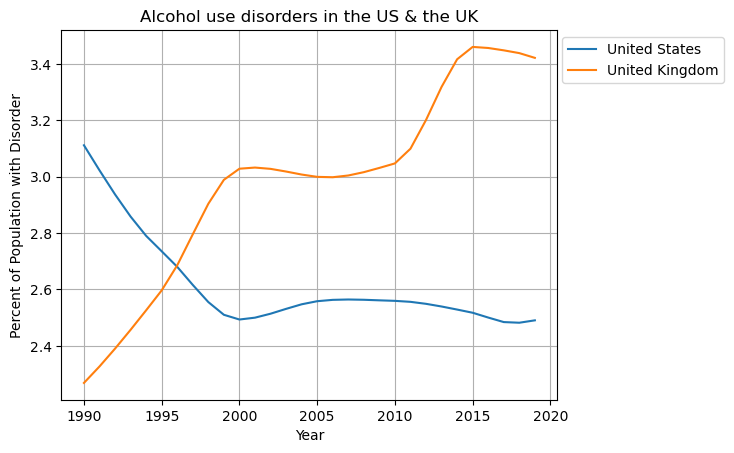

In [13]:
# Plot comparing DALYs between the US and the UK
us_df = dalys_df[dalys_df['Entity'] == 'United States']
uk_df = dalys_df[dalys_df['Entity'] == 'United Kingdom']
plt.plot(us_df['Year'], us_df['DALYs'])
plt.plot(uk_df['Year'], uk_df['DALYs'])
plt.title('DALYs in the US & the UK')
plt.xlabel('Year')
plt.ylabel('Disability Adjusted Life Years')
plt.legend(['United States', 'United Kingdom'], bbox_to_anchor=(1.35, 1))
plt.grid()
plt.savefig(Path('media', f"us_uk_dalys.png"), bbox_inches="tight")
plt.show()

# Plots comparing individual mental illness prevalence between the US and the UK
us_df = disease_df[disease_df['Entity'] == 'United States']
uk_df = disease_df[disease_df['Entity'] == 'United Kingdom']
for d in diseases:
    plt.plot(us_df['Year'], us_df[d])
    plt.plot(uk_df['Year'], uk_df[d])
    plt.title(f'{d} in the US & the UK')
    plt.xlabel('Year')
    plt.ylabel('Percent of Population with Disorder')
    plt.legend(['United States', 'United Kingdom'], bbox_to_anchor=(1.35, 1))
    plt.grid()
    plt.savefig(Path('media', f"us_uk_{d}.png"), bbox_inches="tight")
    plt.show()

## Observartions
-  There is obvious separation between the prevalence of schizophrenia, bipolar disorder, anxiety disorders, and drug use disorders between the US and the UK.
-  DALYs along with eating, depressive, and alcohol use disorders are more intertwined. They must be analyzed statistically.

In [14]:
us_uk_df = pd.DataFrame(columns=['Disorder', 'United States Mean', 'United Kingdom Mean', 'p-value', 'Result'])

# Compare the country DALYs means...
us_df = dalys_df[dalys_df['Entity'] == 'United States']['DALYs']
us_mean = us_df.mean()

uk_df = dalys_df[dalys_df['Entity'] == 'United Kingdom']['DALYs']
uk_mean = uk_df.mean()

# ... Then use a t-test to verify statistical significance.
pvalue = stats.ttest_ind(us_df, uk_df, equal_var=False).pvalue

result = ''
if pvalue < 0.05:
    if us_mean > uk_mean:
        result = 'The United States is more ill'
    else:
        result = 'The United Kingdom is more ill'
else:
    result = 'Statistically insignificant'

row = pd.DataFrame([['DALYs', us_df.mean(), uk_df.mean(), pvalue, result]], columns=['Disorder', 'United States Mean', 'United Kingdom Mean', 'p-value', 'Result'])
us_uk_df = pd.concat([us_uk_df, row])

# For each disease...
for d in diseases:
    # ... First compare the coutry means...
    us_df = disease_df[disease_df['Entity'] == 'United States'][d]
    us_mean = us_df.mean()

    uk_df = disease_df[disease_df['Entity'] == 'United Kingdom'][d]
    uk_mean = uk_df.mean()
    
    # ... Then use a t-test to verify statistical significance.
    pvalue = stats.ttest_ind(us_df, uk_df, equal_var=False).pvalue
    
    result = ''
    if pvalue < 0.05:
        if us_mean > uk_mean:
            result = 'The United States is more ill'
        else:
            result = 'The United Kingdom is more ill'
    else:
        result = 'Statistically insignificant'

    row = pd.DataFrame([[d, us_df.mean(), uk_df.mean(), pvalue, result]], columns=['Disorder', 'United States Mean', 'United Kingdom Mean', 'p-value', 'Result'])
    us_uk_df = pd.concat([us_uk_df, row])

us_uk_df = us_uk_df.reset_index(drop=True)
us_uk_df

,Disorder,United States Mean,United Kingdom Mean,p-value,Result
0,DALYs,7.072814,6.816213,2.916712e-02,The United States is more ill
1,Schizophrenia,0.489256,0.279137,2.620987e-55,The United States is more ill
2,Bipolar disorder,0.656705,1.191317,1.814574e-59,The United Kingdom is more ill
3,Eating disorders,0.481803,0.424886,6.787528e-12,The United States is more ill
4,Anxiety disorders,6.238871,4.778226,5.318901e-15,The United States is more ill
5,Drug use disorders,2.874526,2.078981,4.698605e-11,The United States is more ill
6,Depressive disorders,4.755258,4.551399,1.509800e-04,The United States is more ill
7,Alcohol use disorders,2.613989,2.980253,5.528266e-06,The United Kingdom is more ill


## Observations
**The United Kingdom is mentally healthier than the United States**
-  The United States population has larger DALYs and suffers more from schizophrenia, eating disorders, anxiety, drug use, and depressive disorders.
-  The United Kingdom population suffers more from bipolar and alcohol use disorders.
-  The t-test results validate each of these assertions.

# Question #4 - Is there any correlation in mental illness prevalence year-over-year?

Analysis of trend of Diseases by Country using a liner regression.

For each Disease in each country, calculate a linear regrestion line of ( y = prelience in the population, x= year )
    - The r-value of the regression line is used to see if there is a correlation between years and disease prevelance in a country (R values of .7 are used to filter meaningfull correlations)
    - Slope value of the regression line is % year - over - year change. Positive slope means that the disease in the county is increasing, Negative slope means it is decreasing. 

After calcuation are complete, the top 5 increasing and the top 5 decreasing Diseases by Country are outputed. 

A bar chart of the slope is created and annotated. 

To see what the general trend is, a calcualation of the number of disease by country with a postive slope and a correlation of more .7 is divided by the number of disease by country with correlation of more .7.

In [20]:
trend = pd.DataFrame(columns = ['Country','Diseases','Slope','R-Value'])

for c in disease_df['Entity'].unique():
    df = disease_df[disease_df['Entity'] == c]
    for d in diseases:
        (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df['Year'], df[d])
        temp = pd.DataFrame([{'Country': c, 'Diseases': d, 'Slope': slope, 'R-Value': rvalue}])
        trend= pd.concat([trend, temp])  

trend_signifin = trend[abs(trend['R-Value']) >= 0.7]

In [21]:
# Top correlation
trend2 = trend_signifin.sort_values(['R-Value'], ascending = False)
trend2.head()

,Country,Diseases,Slope,R-Value
0,South Korea,Eating disorders,0.004446,0.999147
0,El Salvador,Eating disorders,0.001740,0.998893
0,Bolivia,Schizophrenia,0.000359,0.998254
0,Tunisia,Eating disorders,0.001739,0.997940
0,Guinea-Bissau,Drug use disorders,0.001473,0.997370


In [23]:
# Top Increasing disorders Diseases and Country
trend3 = trend_signifin.sort_values(['Slope'], ascending = False)
trend3.head()

,Country,Diseases,Slope,R-Value
0,Mongolia,Alcohol use disorders,0.079552,0.966334
0,Scotland,Alcohol use disorders,0.053381,0.920500
0,United States,Drug use disorders,0.049855,0.983109
0,North America (WB),Drug use disorders,0.047951,0.982782
0,Wales,Alcohol use disorders,0.042899,0.846811


In [24]:
# Top Decreasing disorders Diseases and Country
trend3.tail()

,Country,Diseases,Slope,R-Value
0,Denmark,Depressive disorders,-0.035980,-0.928170
0,Singapore,Depressive disorders,-0.039980,-0.938581
0,Uzbekistan,Alcohol use disorders,-0.041268,-0.880664
0,Estonia,Depressive disorders,-0.044589,-0.960469
0,Cuba,Depressive disorders,-0.045956,-0.957652


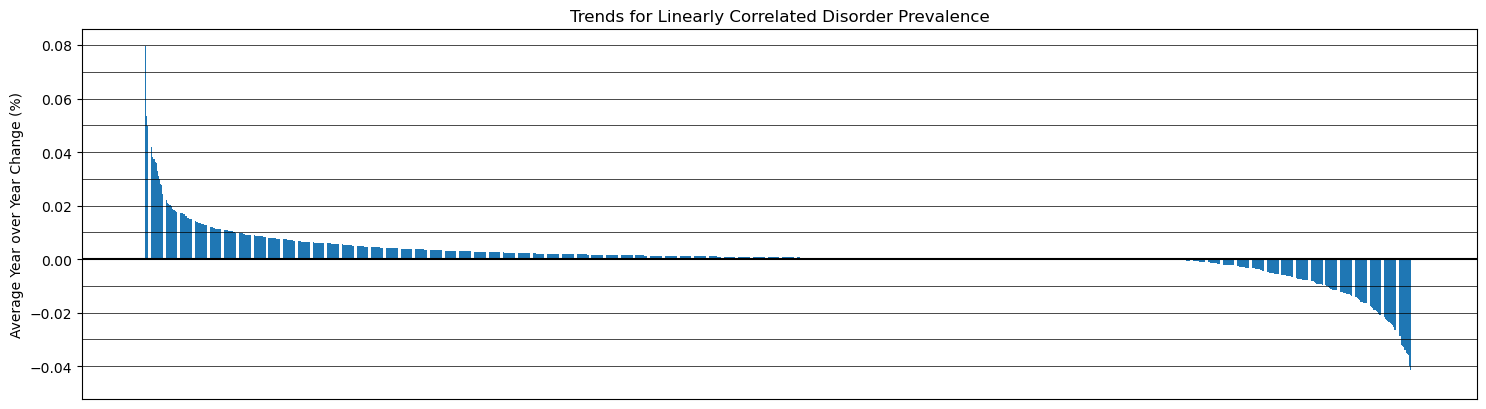

In [33]:
plt.figure().set_figwidth(18)
plt.bar(trend3['Country'] + ' ' + trend3['Diseases'], trend3['Slope'])
plt.xticks(ticks=[]) # Do not display bar labels. x-axis is too crowded. See following analysis.
plt.title('Trends for Linearly Correlated Disorder Prevalence')
plt.ylabel('Average Year over Year Change (%)')
for i in range(-4, 9):
    plt.axhline(y=i/100, c='black', linewidth=0.5)
plt.axhline(y=0, c='black', linewidth=1.5)
plt.savefig(Path('media', "disorder_prevalence_trends.png"), bbox_inches="tight")
plt.show()

## Top disorders trending linearly upward:
1.	Mongolia - Alcohol use disorders	
2.	Scotland - Alcohol use disorders	
3.	United States - Drug use disorders	
4.	North America (WB) - Drug use disorders	
5.	Wales - Alcohol use disorders	

## Top disorders trending linearly downward:
1. Denmark - Depressive disorders	
2. Singapore - Depressive disorders	
3. Uzbekistan  - Alcohol use disorders	
4.	Estonia - Depressive disorders	
5.	Cuba - Depressive disorders	

In [34]:
# Are disorders generatry increasing or decreasing

precent_increasing = trend3[trend3['Slope']>0]['Slope'].count()/ trend3['Slope'].count() 

print(f"The Number of increasing disorders is {precent_increasing:.2%}")

The Number of increasing disorders is 80.46%


# Please do your own mental health a favor by enjoying these cat pictures!

In [35]:
# Here an api is used to query random cat pictures.
url = f'https://api.thecatapi.com/v1/images/search'

def gimme_cats():
    response = requests.request('GET', url)
    if response.status_code ==200:
        cat = response.json()
        cat_url = cat[0]['url']
        display(Image(url = cat_url))
    else:
        print('Cat picture unavailable! Oh the humanity!')

In [36]:
# How many do you NEED?
for num in range(5):
    gimme_cats()